In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 2a)

Generate a sample of configurations {$s_i$} from the probability distribution and store $M$

$$Prob(E)\propto e^{-E/k_BT}$$

$$E=-\sum_{nm}s_is_j$$

$$M=\sum_is_i$$

We will sample the distribution $Prob(E)\propto e^{-E/k_BT}$ using the Metropolis-Hastings algorithm.

1. We will choose a spin at random and consider flipping it from up to down or vice versa according to the acceptance parameter, $\alpha$
2. $\alpha=\dfrac{Prob(E_{new})}{Prob(E_{old})}=e^{-(E_{new}-E_{old})/k_BT}=e^{-\Delta E/k_BT}$ $\longrightarrow \Delta E=2s_i(s_{up}+s_{down}+s_{left}+s_{right})$

if $\alpha>1$ accept spin flip.
Otherwise accept spin flip with probability $\alpha$

3. Update spin array

Side note: The formulas for calculating neighbouring spins was taken from https://medium.com/@natsunoyuki/simulating-magnetism-with-python-a15f7c3042f1

In [2]:
def Get_alpha(si,su,sd,sl,sr,kBT):
    '''Accepts spin, neighbouring spins, kbT'''
    '''Returns probability of spin flip'''
    DeltaE = 2*si*(su+sd+sl+sr)
    alpha = np.exp(-DeltaE/kBT)  
    return alpha  

def Metropolis_Hastings(n,kBT,num_iter):
    '''Accepts length of square spin lattice (n), temperature (kBT)'''
    '''Accepts number of iterations for algorithm (num_iter)'''
    '''Returns chain of magnetization values (M)'''

    # Construct array of randomly oriented spins for starting sample in 2^N parameter space
    spin = np.random.default_rng().integers(0,2,n**2)
    spin[spin == 0] = -1

    M = np.empty(num_iter) # Initialize array for collecting magnetizations
    M[0] = np.sum(spin) # Calculate initial magnetization

    count = 0

    for i in range(num_iter):

        # Proposal
        coord = np.random.default_rng().integers(0,n**2) # choose random 1d spin coordinate
        # extract xy coords of the chosen 1d coordinate
        x = np.mod(coord, n)
        y = coord // n

        si = spin[coord] # center spin
        su = spin[x + np.mod(y - 1 + n, n) * n] # up
        sd = spin[x + np.mod(y + 1, n) * n]     # down
        sl = spin[np.mod(x - 1 + n, n) + y * n] # left
        sr = spin[np.mod(x + 1, n) + y * n]     # right


        # Accept the move or stay where we are
        u = np.random.default_rng().uniform()
        alpha = Get_alpha(si,su,sd,sl,sr,kBT)
        if u <= alpha:
            # accept spin flip and update spin array
            spin[coord] = -si
            count = count + 1
        M[i] = np.sum(spin)
    #print("Acceptance fraction = %g" % (count/num_iter,))
    return M   

Text(0, 0.5, 'Occurences')

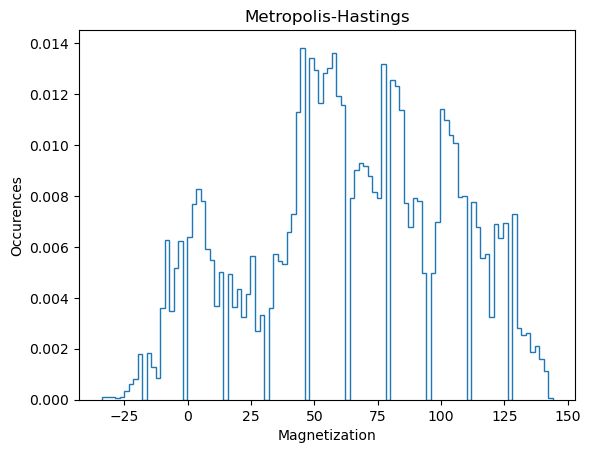

In [3]:
# spin lattice is square with length n and N spins (N=n^2) and at specific temperature kBT
n = 20
num_iter = 10**5 # generate num_iter samples

M = Metropolis_Hastings(n,1,num_iter)

# Plot the distribution  
plt.title('Metropolis-Hastings')
counts, bins = np.histogram(M, bins=100, density = True)
plt.stairs(counts, bins)
plt.xlabel('Magnetization')
plt.ylabel('Occurences')

## 2b)
Now we look at magnetization chains for different temperatures.

In [4]:
# spin lattice is square with length n and N spins (N=n^2) and at specific temperature kBT
n = 20
num_iter = 10**5 # generate num_iter samples

M1 = Metropolis_Hastings(n,1,num_iter)
M2 = Metropolis_Hastings(n,2,num_iter)
M3 = Metropolis_Hastings(n,3,num_iter)
M4 = Metropolis_Hastings(n,4,num_iter)

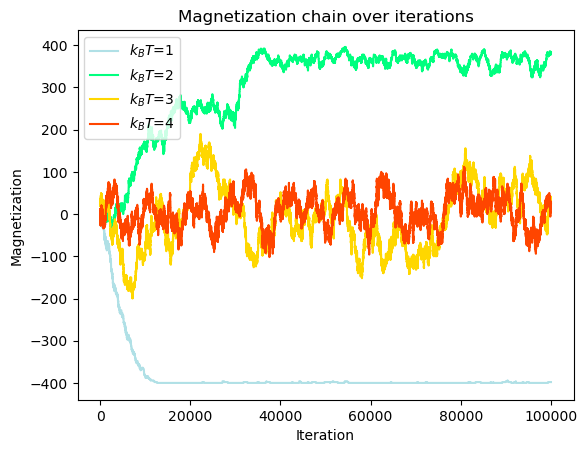

In [5]:
x = np.arange(num_iter)
plt.title('Magnetization chain over iterations')
plt.ylabel('Magnetization')
plt.xlabel('Iteration')
plt.plot(x,M1,color='powderblue',label='$k_BT$=1')
plt.plot(x,M2,color='springgreen',label='$k_BT$=2')
plt.plot(x,M3,color='gold',label='$k_BT$=3')
plt.plot(x,M4,color='orangered',label='$k_BT$=4')
plt.legend()

At low temperatures, we see that pretty quickly we reach an ordered state where all spins align. The burn in phase at T=1 for example lasts about 10000 iterations. At T=2, it lasts about 40000. At high temperatures, we see that we never reach an ordered state. Physically, what is happening is that thermal fluctuations are constantly perturbing any order in the spin state.

## 2c)
Now we plot $\langle M\rangle$ and $Var(M)$ for different temperatures

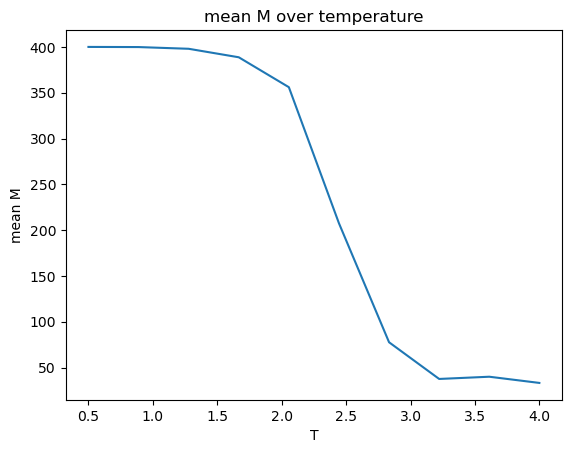

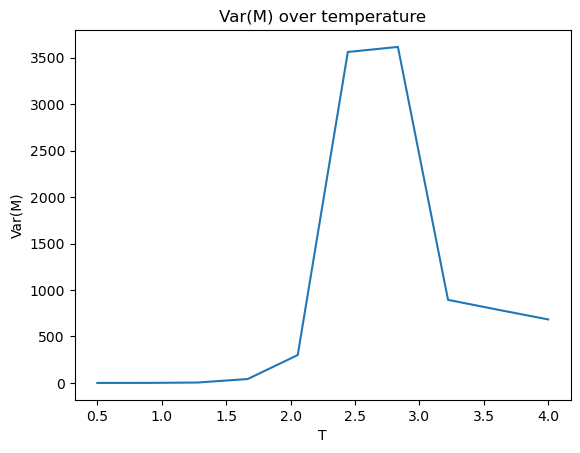

In [19]:
num_T = 10
T = np.linspace(0.5,4,num_T)
burnin = 100000

mean_M = np.empty(num_T)
var_M = np.empty(num_T)

for i in range(num_T):
    M = Metropolis_Hastings(20,T[i],2*10**5)
    mean_M[i] = np.mean(np.abs(M[burnin:])) # don't include M values from burnin
    var_M[i] = np.var(np.abs(M[burnin:]))

plt.figure(1)
plt.title('mean M over temperature')
plt.xlabel('T')
plt.ylabel('mean M')
plt.plot(T,mean_M)

plt.figure(2)
plt.title('Var(M) over temperature')
plt.xlabel('T')
plt.ylabel('Var(M)')
plt.plot(T,var_M)

We see a clear dip in magnetization and a peak in the variance at $k_BT$ = 2.5, indicating a phase transition at $k_BT$ = 2.5. Below 2.5, we have an ordered phase and above, we get a disordered phase. We've run the simulation for $2\times 10^5$ iterations and rejected the first $10^5$ so that we don't include the burnin phase. This being said, if you run the above cell multiple times, sometimes even below 2.5 there is an erratic drop in the phase order - sometimes, the metropolis hastings algorithm results in the chain being stuck. The above cell takes a while to run due to taking so many iterations, but you can shorten it by setting the number of iterations in Metropolis_Hastings to $10^4$ instead of $2\times10^5$. 